# Practical 5: Graph Neural Networks

In this practical, we'll be using some of the GNN architectures discussed in class to predict the solubility of small molecules (using our old friend, the ESOL database).

In [3]:
import os
import sys

sys.path.append('../')

from utils.constants import HOME_DIR, DATA_DIR

In [1]:
! pip install rdkit
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import torch
import matplotlib.pyplot as plt

## Part 1: Semi-Supervised Learning with GCNs

Our first approach will be to apply a standard Graph Convolutional Network (GCN) to the data.

We first need a function that, given a molecule (as represented by a SMILES string), returns the molecular graph (i.e. a matrix of feature vectors for each atom and the adjacency matrix; we'll also return the number of atoms in the molecule, for use later). This function is written for you below. For the sake of simplicity, we will use a simple one-hot encoding of atomic number for our atom features. More complicated graphs could make use of any other atom-level descriptors available in RDKit.


In [2]:
def generate_graph(smile):

    def get_atom_hash(atomic_number):
        """ A helper function to quickly encode atomic number into a one-hot vector """
        atomic_number_list = [6, 7, 8, 9, 15, 16, 17, 35, 53]
        if atomic_number in atomic_number_list:
            return atomic_number_list.index(atomic_number)
        else:
            return len(atomic_number_list)

    def encode_atom(atom):
        """ Generates the vector of features for an atom in a molecule"""
        atom_matrix = np.zeros(10)
        atom_matrix[get_atom_hash(atom.GetAtomicNum())] = 1
        return atom_matrix

    m = AllChem.MolFromSmiles(smile)
    m = AllChem.AddHs(m)
    AllChem.ComputeGasteigerCharges(m)
    atom_matrix = np.array(list(map(encode_atom, (atom for atom in m.GetAtoms()))))
    adj_matrix = AllChem.GetAdjacencyMatrix(m) + np.identity(m.GetNumAtoms()) # Augmented Adjacency Matrix

    return(atom_matrix, adj_matrix, m.GetNumAtoms())

We can load in the ESOL data and verify that our function is operational on the first molecule, amigdalin:

In [4]:
esol_data = pd.read_csv(DATA_DIR + 'clean_data.csv')
amigdalin = esol_data['Canonical_QSARr'][0]
print(amigdalin)
print(generate_graph(amigdalin)[2])

[O-][N+](=O)C1C=CC(Cl)=CC=1
14


Recall that one of the inconveniences of the standard GCN approach for molecular-level features is that we must concatenate the atomic features of ALL molecules in our data into one huge matrix, and concatenate the adjacency matrices of ALL molecules in our data into one huge, block-diagonal adjacency matrix. For convenience, we'll also generate a mask matrix that will allow you to sum-aggregate atom features by molecule through simple matrix multiplication.

If we do this for the ESOL data (about 15,000 atoms), we'll run into memory issues on Deepnote. Below, we construct these matrices for just the first 100 molecules in ESOL.

In [16]:
n_samples = 100

feature_matrices = []
adj_matrices = []
molecule_membership = []
for i in range(n_samples):
    feature_matrix, adj_matrix, n_atoms = generate_graph(esol_data['Canonical_QSARr'][i])
    feature_matrices.append(feature_matrix)
    adj_matrices.append(adj_matrix)
    molecule_membership = np.concatenate((molecule_membership, [i]*n_atoms))

big_feature_matrix = np.concatenate(feature_matrices, axis = 0)
print(np.shape(big_feature_matrix))

big_adj_matrix = linalg.block_diag(*adj_matrices)
print(np.shape(big_adj_matrix))

masks = torch.tensor(np.array([np.where(molecule_membership == i, 1, 0) for i in range(n_samples)])).double()
print(np.shape(masks))

(2658, 10)
(2658, 2658)
torch.Size([100, 2658])


### Exercise 1: Writing a GCN Module

Below, write a torch module that will output molecule-level solubility predictions for each molecule contained in the ESOL data set. This should consist of three GCN layers, an aggregation of each molecules' atom features, and a final linear layer to predict solubility (see Lecture 6 for more detail).

(Pro Tip: You can calculate the normalized graph laplacian once, outside of the module, and pass it to the module as an argument, if you choose.)

In [17]:
### Optional Preprocessing Here ###
degree_vector = np.sum(big_adj_matrix, axis=1)
degree_vector = np.diag(1/np.sqrt(degree_vector))
D = torch.tensor(degree_vector)
A = torch.tensor(big_adj_matrix)
norm_graph_laplacian = D @ A @ D

class SolNet(torch.nn.Module):
    def __init__(
            self, 
            laplacian, 
            molecule_masks, 
            input_size = 10, 
            internal_size = 10, 
            output_size = 1, 
            num_conv_layers = 3, 
            activation_function=torch.nn.functional.relu
        ):
        super().__init__()
        ### Your Code Here ###
        self.laplacian = laplacian
        self.masks = molecule_masks
        self.W0 = torch.nn.Parameter(0.1*torch.randn((input_size, internal_size)))
        self.W1 = torch.nn.Parameter(0.1*torch.randn((internal_size, internal_size)))
        self.W2 = torch.nn.Parameter(0.1*torch.randn((internal_size, internal_size)))
        self.W3 = torch.nn.Parameter(0.1*torch.randn((internal_size, output_size)))
        self.activation_function = activation_function
        

    def forward(self, x):
        """Computes the prediction of the neural network"""
        ### Your Code Here ###
        x = self.activation_function(self.laplacian.double() @ x @ self.W0.double())
        x = self.activation_function(self.laplacian.double() @ x @ self.W1.double())
        x = self.activation_function(self.laplacian.double() @ x @ self.W2.double())
        x = self.masks @ x
        y = x @ self.W3.double()

        return y

Now that you've created a module for predicting solubilities, let's train it!

Recall that in this block GCN implementation, we take a 'semi-supervised' learning approach. That is, we train using the block matrices will ALL of our data, but we only label SOME of the target values. We calculate gradients based off of the loss on the labelled data, and use the loss on the unlabelled data as our 'test' performance.

Below, the targets are created for you, and indices representing a 66%/33% train-test split are generated for your use.

In [18]:
## Create Targets
targets = torch.tensor(esol_data['LD50_mgkg'][:n_samples])

# Only train on 2/3 of points
labelled_indices = np.random.choice(np.arange(n_samples), int(2*n_samples/3), replace = False)
unlabelled_indices = np.setdiff1d(np.arange(n_samples), labelled_indices)

### Exercise 2: Training your GCN model on the ESOL data

Below, train your model on the ESOL solubility targets. Plot the train and test losses as training progresses, and report the final (MSE) train and test loss for your model. Make a comparison to the Random Forest model that we used in Practical 2.

(Note that this will be an imperfect comparison because we are only using a subset of the data)

/var/folders/km/cvdycj097l576cncjdnqjchr0000gn/T/ipykernel_10964/2553096703.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = self.activation_function(self.laplacian.double() @ x @ self.W0.double())


Epoch 0 | Train Loss: 7983022.56597 Test Loss: 48231661.85765
Epoch 10 | Train Loss: 7978097.56590 Test Loss: 48220788.71276
Epoch 20 | Train Loss: 7911711.15183 Test Loss: 48075641.72752
Epoch 30 | Train Loss: 7543290.56211 Test Loss: 47258721.11899
Epoch 40 | Train Loss: 6347128.70483 Test Loss: 44389734.32440
Epoch 50 | Train Loss: 4546941.51798 Test Loss: 38033187.05905
Epoch 60 | Train Loss: 4596436.61970 Test Loss: 34619679.91031
Epoch 70 | Train Loss: 4344596.21829 Test Loss: 37078946.34497
Epoch 80 | Train Loss: 4265342.04175 Test Loss: 36744622.47868
Epoch 90 | Train Loss: 4196627.80377 Test Loss: 35744812.25227
Epoch 100 | Train Loss: 4117089.82184 Test Loss: 36183110.49195
Epoch 110 | Train Loss: 4040644.15863 Test Loss: 36123725.83806
Epoch 120 | Train Loss: 3954764.63589 Test Loss: 35864234.02231
Epoch 130 | Train Loss: 3854355.58521 Test Loss: 35950389.21918
Epoch 140 | Train Loss: 3734816.37748 Test Loss: 35881948.83631
Epoch 150 | Train Loss: 3589151.47248 Test Loss: 35

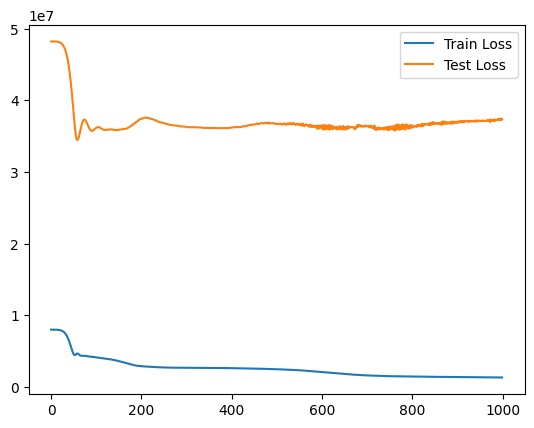

Final Train Loss: 1303405.93833 | Final Test Loss: 37387704.75469


In [19]:
### Train your model here (You can use a very similar approach to the one used in previous practicals) ###
model = SolNet(norm_graph_laplacian, masks)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_losses = []
test_losses = []
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = model(big_feature_matrix).squeeze()
    train_loss = criterion(preds[labelled_indices], targets[labelled_indices])
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.detach().numpy())

    test_loss = criterion(preds[unlabelled_indices], targets[unlabelled_indices])
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()
# Print final train and test loss (5 decimal places)
print(f"Final Train Loss: {train_losses[-1]:.5f} | Final Test Loss: {test_losses[-1]:.5f}")


## Part 2: Supervised Learning with Message Passing

The GCN architecture as implemented above is a little clunky; it deals with huge matrices and generalizes poorly due to the fact that we are limited to a 'full batch' approach. In lecture, we discussed a message passing approach that learns a transformation involving local graph information that can be deployed on unobserved graphs.

One aspect of this message passing framework as presented in lecture was an embedding in 3-dimensional coordinates to preserve physical invariances. For the sake of simplicity, we will not do that here, and instead only focus on message passing on static graphs.

### Exercise 3: Writing a Message Passing Module

Below, implement a PyTorch module that performs a simple message passing transformation as discussed in class. As a reminder, the message passing layer should:

1. For each atom in the molecule, compute a 'message' recieved from each atomic neighbor based on the current node features of the two neighboring atoms
2. Compose the incoming messages into a single, aggregated message
3. Update the node features of the atom based on the current features and the aggregated message

For molecule-level predictions, you can then compose all atom-level features and pass through a fully-connected layer to produce an output.

In [12]:
class MPNet(torch.nn.Module):
    def __init__(self, n_features, activation_function=torch.nn.functional.relu):
        super().__init__()
        ### Your code here ###
        self.n_features = n_features
        self.activation_function = activation_function

        self.W1 = torch.nn.Parameter(0.1*torch.randn((n_features*2, n_features)))
        self.b1 = torch.nn.Parameter(0.1*torch.randn(n_features))
        self.W2 = torch.nn.Parameter(0.1*torch.randn((n_features*2, n_features)))
        self.b2 = torch.nn.Parameter(0.1*torch.randn(n_features))
        self.W3 = torch.nn.Parameter(0.1*torch.randn((n_features, 1)))

    def forward(self, feats, adj):
        """Computes the prediction of the neural network"""
        ### Your code here ###
        messages = torch.stack(
            [
                sum(
                    [
                        self.activation_function(torch.hstack((feats[i], feats[j])) @ self.W1 + self.b1) for j in np.where(adj[i]==1)[0]
                    ]
                ) for i in range(len(feats))
            ]
        )

        feats = self.activation_function(torch.hstack((feats, messages)) @ self.W2 + self.b2)

        y = torch.sum(feats, axis=0) @ self.W3
        return y

### Exercise 4: Training your Message Passing Network on ESOL

Repeat the procedure for Exercise 2, this time using your message passing framework on the same 100-graph subset of the ESOL data (you can use the same 'train/test split' as given above, though it will function slightly differently now that we are doing regular supervised learning). Compare the performance to that of the GCN.

Epoch 0 | Train Loss: 3800749.69197 Test Loss: 2528760.10926
Epoch 10 | Train Loss: 3774436.26644 Test Loss: 2505157.75771
Epoch 20 | Train Loss: 3588325.02978 Test Loss: 2349658.75738
Epoch 30 | Train Loss: 2941616.98502 Test Loss: 1846796.17144
Epoch 40 | Train Loss: 1728305.51350 Test Loss: 1031212.30600
Epoch 50 | Train Loss: 1136049.17384 Test Loss: 902531.08536
Epoch 60 | Train Loss: 1117594.27729 Test Loss: 896394.92425
Epoch 70 | Train Loss: 1036849.90711 Test Loss: 830146.79844
Epoch 80 | Train Loss: 983317.04959 Test Loss: 847074.64308
Epoch 90 | Train Loss: 942639.18207 Test Loss: 883075.37891
Epoch 100 | Train Loss: 899177.64465 Test Loss: 869517.42490
Epoch 110 | Train Loss: 858701.24807 Test Loss: 871801.06239
Epoch 120 | Train Loss: 815928.90133 Test Loss: 888147.82176
Epoch 130 | Train Loss: 772624.76572 Test Loss: 893342.98402
Epoch 140 | Train Loss: 730430.07039 Test Loss: 901149.64872
Epoch 150 | Train Loss: 693593.81812 Test Loss: 912502.26528
Epoch 160 | Train Loss

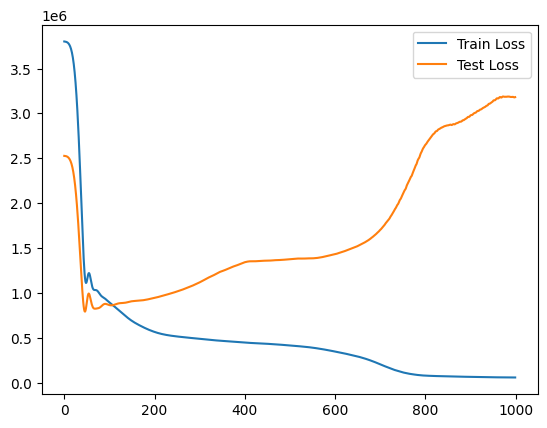

Final Train Loss: 64710.53614 | Final Test Loss: 3181718.70185


In [15]:
### Train your model here (You can use a very similar approach to the one used in previous practicals) ###
# Note that training here can be slow if your module is not sufficiently vectorized. It might
# be helpful to reduce n_samples to make sure your architecture is working properly before trying to apply
# to larger data.

model = MPNet(10).double()
num_epochs = 1000
learning_rate = 0.01
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_train_loss = []
all_test_loss = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for i in labelled_indices:
        pred = model(torch.tensor(generate_graph(esol_data['Canonical_QSARr'][i])[0]), torch.tensor(generate_graph(esol_data['Canonical_QSARr'][i])[1]))
        loss = torch.mean((pred - targets[i])**2)
        epoch_loss += loss
    opt.zero_grad()
    epoch_loss.backward()
    opt.step()
    all_train_loss.append((epoch_loss/len(labelled_indices)).detach().numpy())

    epoch_test_loss = 0
    with torch.no_grad():
        for i in unlabelled_indices:
            pred = model(torch.tensor(generate_graph(esol_data['Canonical_QSARr'][i])[0]), torch.tensor(generate_graph(esol_data['Canonical_QSARr'][i])[1]))
            loss = torch.mean((pred - targets[i])**2)
            epoch_test_loss += loss
    all_test_loss.append((epoch_test_loss/len(unlabelled_indices)).detach().numpy())
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Train Loss: {all_train_loss[-1]:.5f} Test Loss: {all_test_loss[-1]:.5f}')

plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_test_loss, label='Test Loss')
plt.legend()
plt.show()
# Print final train and test loss (5 decimal places)
print(f"Final Train Loss: {all_train_loss[-1]:.5f} | Final Test Loss: {all_test_loss[-1]:.5f}")



The test loss is smaller for the GCN.